<h1>Train The Model<h1>

In [1]:
# fastai-specific stuff.
# Import fastai code.
from fastai.vision.all import *

# Set a seed so that the results are the same every time this is run.
set_seed(0)

In [2]:
# Show what GPU we have.
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(0))
else:
    print("No CUDA.")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12050MB, multi_processor_count=28)


In [3]:
train_dataset_path = untar_data('https://students.cs.calvin.edu/~sc77/images.zip')
train_images = get_image_files(train_dataset_path)
train_labels = [img.parent.name.upper() for img in train_images]

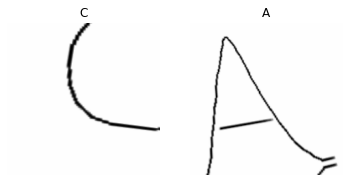

In [4]:
dataloaders = ImageDataLoaders.from_lists(
    path = train_dataset_path, fnames=train_images, labels=train_labels,
    valid_pct=0.2,
    seed=42,
    bs=2,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(size=224)
)
dataloaders.show_batch()

In [5]:
dataloaders.train.n

60

In [6]:
sizes_of_images_in_batch = [image_batch.shape[0] for image_batch, label_batch in dataloaders.train]
print(f'{len(train_images)} total images: {dataloaders.train.n} in train set, {dataloaders.valid.n} in valid set')
print(f'Training data loader gave us {len(sizes_of_images_in_batch)} batches in an epoch')
print(f'Each batch had {set(sizes_of_images_in_batch)} images.')
print(f'So the learner will get trained on a total of {sum(sizes_of_images_in_batch)} images.')

75 total images: 60 in train set, 15 in valid set
Training data loader gave us 30 batches in an epoch
Each batch had {2} images.
So the learner will get trained on a total of 60 images.


In [7]:
learn = vision_learner(
    dls = dataloaders,
    arch=resnet34,
    metrics=[accuracy]
)

In [8]:
saved_clf_filename = 'classifier.pth'
try:
    learn.load(saved_clf_filename)
    print("Loaded saved learner")
except FileNotFoundError:
    # Note that save/load is odd; it actually saves and loads from (learn.path/learn.model_dir/filename).
    # Maybe we should be using learn.export()?
    print("Running fine-tuning")
    learn.fine_tune(epochs=10)
    learn.recorder.plot_loss()
    learn.save(saved_clf_filename)

Loaded saved learner


<h1>Load the test set<h1>

Here's the code for getting the test set loaded. The basic approach is the same as constructing the DataLoaders above, but instead of making brand new `dataloaders`, we make a new dataloader that's like the original one but using a new set of images. (This is different than creating a new dataloaders because we don't want to split the new data into a training set and validation set; we want to use the whole thing.)

We're giving it the labels so that we can diagnose the results. In a Kaggle-style competition format, you won't get the true labels, so you'll just use `dataloaders.test_dls(test_images, with_labels=False)`.

In [9]:
test_url = 'https://students.cs.calvin.edu/~ka37/letter_images_dataset_v0.zip'
test_dataset_path = untar_data(test_url)

In [10]:
test_images = get_image_files(test_dataset_path)
test_labels = [img.parent.name.upper() for img in test_images]

In [11]:
test_images

(#944) [Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_4_A_18.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_9_upper_a_0.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_6_A (25).png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_8_a32.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_1_A_6.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_4_A_6.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_3_A_27.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_5_a14.jpg'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_4_A_9.png'),Path('/scratch/cs344/data/letter_images_dataset_v0/a/group_5_a5.jpg')...]

In [12]:
# Note: we need to "zip" the filenames together with the corresponding filenames.
# To see how `zip` works, try looking at the output of `list(zip(test_images[:5], test_labels))`.
test_dl = dataloaders.test_dl(list(zip(test_images, test_labels)), with_labels=True)

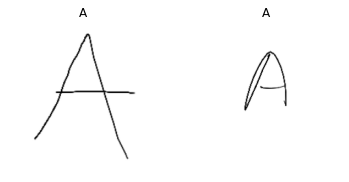

In [13]:
test_dl.show_batch()

<h1>Evaluate our Learner on The Testing Data<h1>

Once we have the test `DataLoader`, we can use it for `ClassificationInterpretation`. By default, the validation set is used, but we can tell it to use `test_dl` instead:

In [14]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)


In [15]:
interp.print_classification_report()


              precision    recall  f1-score   support

           A       0.58      0.61      0.59       332
           B       0.65      0.43      0.52       346
           C       0.52      0.73      0.61       266

    accuracy                           0.58       944
   macro avg       0.59      0.59      0.57       944
weighted avg       0.59      0.58      0.57       944



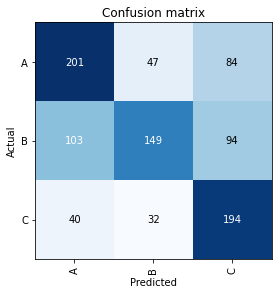

In [16]:
interp.plot_confusion_matrix()


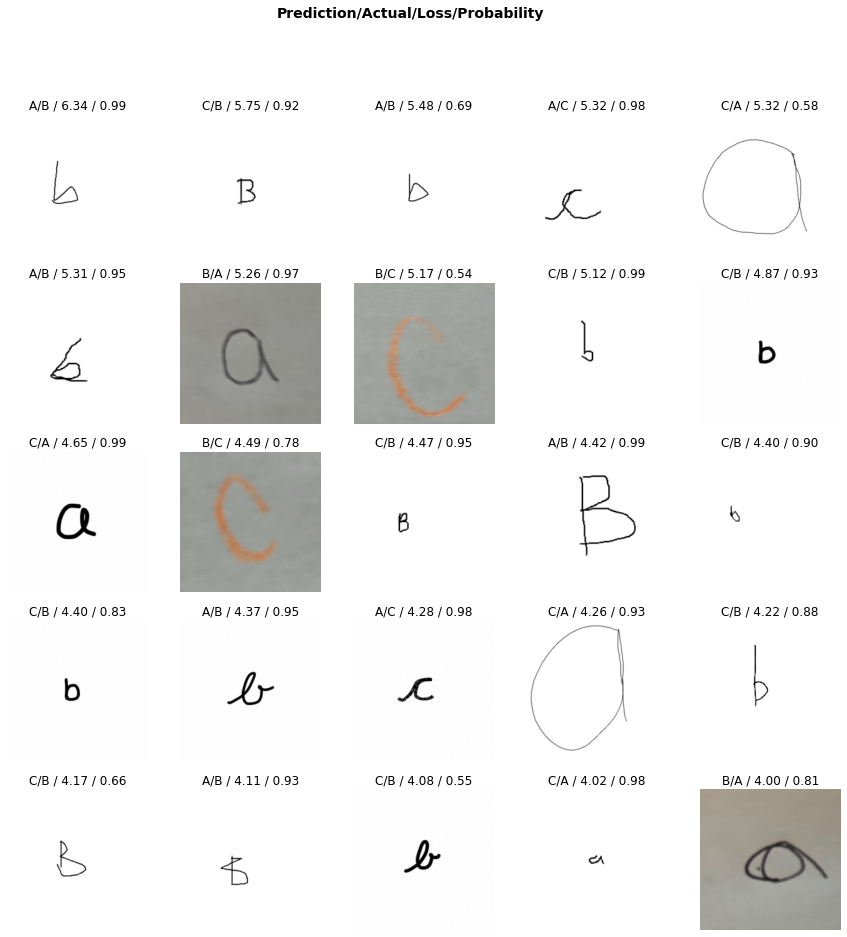

In [17]:
interp.plot_top_losses(25)

This works by treating a correct prediction as a 1 and an incorrect prediction as 0. (I call this the sum-as-count pattern) This code also demonstrates a clean way to spread out a Python expression over multiple lines: put everything in parentheses.

In [18]:
predicted_probs, targets = learn.get_preds(dl=test_dl, with_preds=True, with_targs=True)
# Use the class with the highest predicted probability as the predicted class.
predicted_classes = predicted_probs.argmax(axis=1)

In [19]:
(
    # Make a Tensor of Trues and Falses, True if the classifier got the corresponding image right
    (
        # the predictions that the model made on the test set
        predicted_classes
        # compare with the target labels provided by the DataLoader (we got these from get_preds above)
        == targets
    )
    # convert True to 1.0, False to 0.0
    .to(float)
    # Compute the fraction of True's.
    .mean()
)

TensorBase(0.5763, dtype=torch.float64)

or use: 

In [20]:
accuracy(predicted_probs, targets)

TensorBase(0.5763)

**Report what actual accuracy you got.**

Accuracy : 57.63%

**What were your classifier’s most frequent mistakes? Describe both quantitatively (via the confusion matrix) and qualitatively (by studying the top losses).**

Looking at the confusion matrix,
- I have made mistake 143 / 344 prediction mistakes when looking at A.
- I have made 79 / 228 prediction mistakes when looking at B.
- I have made 178 / 372 prediction mistakes when looking at C.

Looking at the top 25 losses,
- I have made 6 mistakes of A
- I have made 15 mistakes of B
- I have made 4 mistakes of C
</br>

Thus **quantitatively** I have most mistakes in C and **qualitatively** in B.

**Recall that in Homework 1 you estimated the accuracy that your classifier would obtain on other people’s images. Compare the accuracy you observe to the accuracy that you thought you’d get.**

It's far lower than what I expected from my model. **Hw 1 Estimate Accuracy was 78%**. However, with other people's data it lowered to **57.63%**. I think it's because of more outliers of the data. Again Too little data for the outliers. 

**Now let’s write a datasheet for the specific training data you collected. Read the introduction to the Dataset Documentation (Datasheets for Datasets) template. Then, skim through the questions that follow. Choose two or three questions that are most relevant to how well the model that you trained worked on new data. At the end of your notebook, include both the question texts and your answers.**

- How was the data validated/verified?</br></br>
It was verified by students labeling images appropriately according to the letter drawn. </br></br>
- How was the data collected?</br></br>
Data was collected by hand written letters either on sketch web app, paper, or a whiteboard. Then, it was saved into a zip file appropriately named after intended written letter. </br></br>
- What are other potential data quality issues a user of this dataset needs to be aware of?</br></br>
There are multiple issues with the data. First of all, it's very diverse. Not that diverse data is bad, but some data has outliers which does not have enough backup data for AI to train on. If there were images where people intentionally drew it badly or messily, there needs to be more image datasets on that outliers, but there aren't which makes the training more difficult and inaccurate. </br></br>

**Go back to your Homework 1 classifier. Make one change to how the classifier is trained. Evaluate the change in accuracy you observe during training, and the change in accuracy you observe here.**

Initially when I used reset18, it had higher accuracy, but when I used resnet34 accuracy dropped down slightly. 


I also tried changing the epoch few times, saved it as classifier.pth_1 and classifier.pth_2....and so on...It lowered the accuracy only. 